In [127]:
import pandas as pd
import matplotlib.pyplot as plt

Below is a dictionary of drinks. These are the drinks being considered as part of the experiment as "milk containing" drinks. It includes hot and cold milk which is an add on, generally ordered with americanos. The keys in the dictionary are the 'PLU codes' from the electronic point of sale system (EPOS) used in the café. Note that there are some drinks that sit in a grey area such as teas, which may or may not be served with milk. English Breakfast and Decaf tea have been included as I have been informed by a barista at the cafe that these are typically served with wilk. Earl Grey has been excluded as is often is served without milk. Babychinos have also been excluded as they are provided to young children for free. Both of these drinks make up a very small percentage of the total drinks sold so their exclusion will not have a significant impact on the results.

The milk options and their codes are also specified in a dictionary below.

In [128]:
# Numbers correspond to the PLU codes for the drinks (from the EPOS system)
milk_containing_drinks = {1: 'Flat White', 4: 'Cappuccino', 5: 'Latte', 10: 'Iced Chai', 12: 'Hot Chocolate',
                          14: 'Matcha Latte', 15: 'Beetroot Latte', 16: 'Tumeric Latte', 35: 'Iced Mocha', 36: 'Mini Hot Choc',
                          38: 'English Breakfast', 40: 'Decaf Tea', 42: 'Iced Chocolate', 62: 'Mocha',
                          63: 'Chai Latte', 283: 'Cold Milk', 341: 'Iced Latte', 906: 'Hot Milk', 908: 'Cold Milk'}
# milk_containing_drinks = {1: 'Flat White', 4: 'Cappuccino', 5: 'Latte', 10: 'Iced Chai', 12: 'Hot Chocolate',
#                           14: 'Matcha Latte', 15: 'Beetroot Latte', 16: 'Tumeric Latte', 35: 'Iced Mocha', 36: 'Mini Hot Choc',
#                           42: 'Iced Chocolate', 62: 'Mocha',
#                           63: 'Chai Latte', 341: 'Iced Latte'}

milk_alterations = {139: 'COCONUT MILK', 901: 'OAT MILK', 949: ' DAIRY MILK'}

Below is a class which contains all of the logic for reading the raw csv files from the EPOS system, processing the data and producing reports on the data. The class takes in a folder path and then processes every csv file in that folder. The data is split into morning (8:30am to 11:59am) and afternoon (12:00pm to 16:30pm) for each day in the trial and baseline phases. I split the data into morning and afternoon following an early observation that there appeared to be a difference in the data between the two time periods.

The processing involves extracting the relevant items and their quantities. The quantity of milk alternatives are subtracted from the total number of drinks (which are assumed to be served with the default recorded milk option). This results in a count of the number of drinks with each alternative (explicitly recorded) milk option and the number of drinks with the default (assumed/implicitly recorded) milk option.

In [129]:
import os
import re

class ReportDataFrame(pd.DataFrame):
    def add_percentage_columns(self, base_columns, total_column):
        for column in base_columns:
            self[f"{column}%"] = self[column] / self[total_column] * 100
        return self
    
    def group_by_time_of_day(self):
        return ReportDataFrame(self.sort_values(by=["day","time_of_day"]).groupby(['time_of_day']).agg({'default_milk': 'first', 'coconut': 'sum', 'oat': 'sum', 'dairy': 'sum', 'total': 'sum', 'black': 'sum'}))
    
    def group_by_day(self):
        return ReportDataFrame(self.sort_values(by=["day","time_of_day"]).groupby(['day']).agg({'default_milk': 'first', 'time_of_day': 'sum', 'coconut': 'sum', 'oat': 'sum', 'dairy': 'sum', 'total': 'sum', 'black': 'sum'}))

    def group_by_week(self):
        # Create a new column 'week' that represents the week number
        self['week'] = (self['day'] - 1) // 7 + 1
        
        # Group by 'week' and aggregate
        return ReportDataFrame(self.sort_values(by=["day","time_of_day"]).groupby(['week']).agg({'day': 'nunique', 'coconut': 'sum', 'oat': 'sum', 'dairy': 'sum', 'total': 'sum', 'black': 'sum'}))

class Report:

    reports = {}

    def __init__(self, folder_path, milk_alterations, milk_containing_drinks):
        self.folder_path = folder_path
        self.milk_alterations = milk_alterations
        self.milk_containing_drinks = milk_containing_drinks

    def add_missing_rows(self, df):
        missing_records = set(self.milk_alterations.keys()) - set(df['RECORD'])
        missing_rows = pd.DataFrame({'RECORD': list(missing_records), 'NAME': [self.milk_alterations[record] for record in missing_records], 'QUANTITY': 0})
        df = pd.concat([df, missing_rows], ignore_index=True)
        return df

    def filter_records(self, df):
        df_milk_containing = df[df['RECORD'].isin(self.milk_containing_drinks.keys())]
        df_milk_alterations = df[df['RECORD'].isin(self.milk_alterations.keys())]
        df_milk_alterations = self.add_missing_rows(df_milk_alterations)
        return df_milk_containing, df_milk_alterations

    def subtract_milk_alterations(self, df_milk_containing, df_milk_alterations, default_milk_record):
        total_milk_containing = df_milk_containing['QUANTITY'].sum()
        total_milk_alterations = df_milk_alterations.loc[df_milk_alterations['RECORD'] != default_milk_record, 'QUANTITY'].sum()
        default_milk_quantity = total_milk_containing - total_milk_alterations
        df_milk_alterations.loc[df_milk_alterations['RECORD'] == default_milk_record, 'QUANTITY'] = default_milk_quantity
        df_milk_alterations.loc[:, 'PERCENTAGE'] = df_milk_alterations.loc[:, 'QUANTITY'] / df_milk_alterations.loc[:, 'QUANTITY'].sum() * 100
        return df_milk_alterations
    
    def extract_day_number(self, file_name):
        match = re.search(r'\d+', file_name)
        return int(match.group()) if match else None
    
    def process_file(self, file_name, report):
        if file_name.endswith('.csv'):
            file_path = os.path.join(self.folder_path, file_name)
            df = pd.read_csv(file_path)
            df.drop('VALUE', axis=1, inplace=True)

            black = df.loc[df['RECORD'] == 905, 'QUANTITY'].values[0] if not df.loc[df['RECORD'] == 905, 'QUANTITY'].empty else 0

            df_milk_containing, df_milk_alterations = self.filter_records(df)

            if file_name.endswith('oat.csv'):
                default_milk_record = 901
            elif file_name.endswith('dairy.csv'):
                default_milk_record = 949
            else:
                print("WARNING: No default milk record found for file: ", file_name)

            result = self.subtract_milk_alterations(df_milk_containing, df_milk_alterations, default_milk_record)
            day_number = self.extract_day_number(file_name)

            time_of_day = 'am' if 'morning' in file_name else 'pm'
            coconut_quantity = result.loc[result['RECORD'] == 139, 'QUANTITY'].values[0] if not result.loc[result['RECORD'] == 139, 'QUANTITY'].empty else 0
            oat_quantity = result.loc[result['RECORD'] == 901, 'QUANTITY'].values[0] if not result.loc[result['RECORD'] == 901, 'QUANTITY'].empty else 0
            dairy_quantity = result.loc[result['RECORD'] == 949, 'QUANTITY'].values[0] if not result.loc[result['RECORD'] == 949, 'QUANTITY'].empty else 0
            total = coconut_quantity + oat_quantity + dairy_quantity

            new_row = pd.DataFrame({
                'day': [day_number],
                'time_of_day': [time_of_day],
                'default_milk': [self.milk_alterations[default_milk_record]],
                'coconut': [coconut_quantity],
                'oat': [oat_quantity],
                'dairy': [dairy_quantity],
                'total': [total],
                'black': [black]
            })

            report = pd.concat([report, new_row], ignore_index=True)
        return ReportDataFrame(report)

    def generate_report(self):
        overall_report = pd.DataFrame(columns=['day', 'time_of_day', 'default_milk', 'coconut', 'oat', 'dairy'])
        
        for file_name in os.listdir(self.folder_path):
            if file_name.endswith('.csv'):
                overall_report = self.process_file(file_name, overall_report)
        
        return overall_report

Below are the reports for the experimental phase. You can see that the default (recorded) milk was oat milk for the first 3 days and then dairy milk for the rest of the trial.

In [161]:
intervention_report = Report('data/', milk_alterations, milk_containing_drinks)
intervention_report_df = intervention_report.generate_report()
milk_types = ["coconut", "oat", "dairy"]

intervention_report_df.add_percentage_columns(milk_types, "total").sort_values(by=["day","time_of_day"])
# intervention_report_df.group_by_time_of_day().add_percentage_columns(milk_types, "total")
# intervention_report_df.group_by_week().add_percentage_columns(milk_types, "total")
# intervention_report_df.group_by_day().add_percentage_columns(milk_types, "total")
# intervention_report_df[["coconut", "oat","dairy", "total"]].sum() / intervention_report_df["total"].sum() * 100

,day,time_of_day,default_milk,coconut,oat,dairy,total,black,coconut%,oat%,dairy%
34,1,am,OAT MILK,1.0,4.0,23.0,28.0,2.0,3.571429,14.285714,82.142857
32,1,pm,OAT MILK,0.0,18.0,10.0,28.0,2.0,0.000000,64.285714,35.714286
3,2,am,OAT MILK,2.0,19.0,25.0,46.0,1.0,4.347826,41.304348,54.347826
36,2,pm,OAT MILK,1.0,17.0,6.0,24.0,1.0,4.166667,70.833333,25.000000
21,3,am,OAT MILK,0.0,26.0,27.0,53.0,4.0,0.000000,49.056604,50.943396
39,3,pm,OAT MILK,1.0,4.0,17.0,22.0,3.0,4.545455,18.181818,77.272727
8,4,am,DAIRY MILK,2.0,14.0,25.0,41.0,1.0,4.878049,34.146341,60.975610
29,4,pm,DAIRY MILK,2.0,3.0,17.0,22.0,0.0,9.090909,13.636364,77.272727
4,5,am,DAIRY MILK,2.0,11.0,28.0,41.0,3.0,4.878049,26.829268,68.292683
30,5,pm,DAIRY MILK,1.0,2.0,26.0,29.0,3.0,3.448276,6.896552,89.655172


I initially intended to take the 3 weeks prior to the experimental phase as the baseline phase. However, the dates for this are ... which overlap with the school Easter holiday. With the experimental phase being entirely outside of school holidays, a comparison with a baseline that covers school holidays could lead to an unfair comparison. It's safe to assume that the customer base will be different during school holidays compared to term time and hence any difference in milk choices.

I then intended to take a basline phase of ... . However, there are two days in this period in which the café was closed for renovation. This again could lead to an unrepresentative comparison.

Therefore, I have taken a baseline phase of ... . This phase avoids school holidays and any days in which the café was closed. I have taken data for all 3 possible baselines to see if there is any significant difference in the results.

In [131]:
report = Report('baseline_data/', milk_alterations, milk_containing_drinks)
report_df = report.generate_report()
milk_types = ["coconut", "oat", "dairy"]

# report_df.add_percentage_columns(milk_types, "total").sort_values(by=["day","time_of_day"])
# report_df.group_by_time_of_day().add_percentage_columns(milk_types, "total")
# report_df.group_by_week().add_percentage_columns(milk_types, "total")
# report_df.group_by_day().add_percentage_columns(milk_types, "total")
report_df[["coconut", "oat","dairy"]].sum() / report_df["total"].sum() * 100

coconut     1.663798
oat        15.662651
dairy      82.673551
dtype: float64

In [132]:
report = Report('baseline_no_holiday/', milk_alterations, milk_containing_drinks)
report_df = report.generate_report()
milk_types = ["coconut", "oat", "dairy"]

# report_df.add_percentage_columns(milk_types, "total").sort_values(by=["day","time_of_day"])
# report_df.group_by_time_of_day().add_percentage_columns(milk_types, "total")
# report_df.group_by_week().add_percentage_columns(milk_types, "total")
# report_df.group_by_day().add_percentage_columns(milk_types, "total")
report_df[["coconut", "oat","dairy"]].sum() / report_df["total"].sum() * 100

coconut     2.261823
oat        18.300206
dairy      79.437971
dtype: float64

In [155]:
baseline_report = Report('baseline_no_holiday2/', milk_alterations, milk_containing_drinks)
baseline_report_df = baseline_report.generate_report()
milk_types = ["coconut", "oat", "dairy"]

# baseline_report_df.add_percentage_columns(milk_types, "total").sort_values(by=["day","time_of_day"])
# baseline_report_df.group_by_time_of_day().add_percentage_columns(milk_types, "total")
# baseline_report_df.group_by_week().add_percentage_columns(milk_types, "total")
# baseline_report_df.group_by_day().add_percentage_columns(milk_types, "total")
baseline_report_df[["coconut", "oat","dairy", "total"]].sum()# / baseline_report_df["total"].sum() * 100

coconut      35.0
oat         268.0
dairy      1311.0
total      1614.0
dtype: float64

In [134]:
intervention_plot = intervention_report_df['day'] = intervention_report_df['day'] + 21

In [135]:
plt.rcParams['font.sans-serif'] = ['Helvetica Neue']

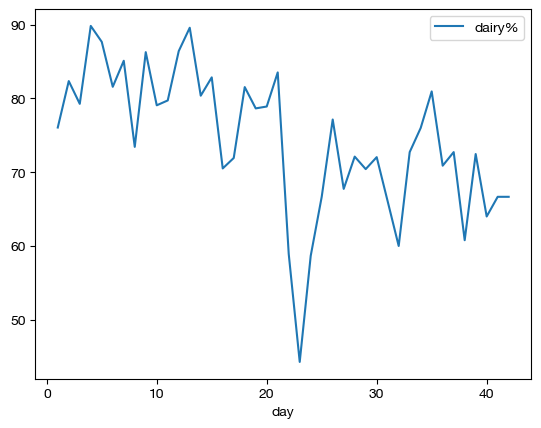

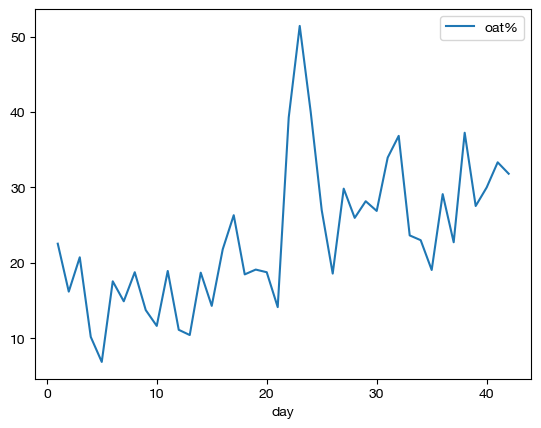

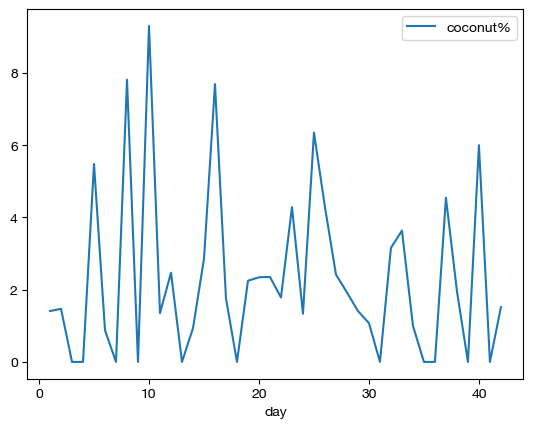

In [136]:
intervention_plot = intervention_report_df.group_by_day().add_percentage_columns(milk_types, "total").reset_index()
baseline_plot = baseline_report_df.group_by_day().add_percentage_columns(milk_types, "total").reset_index()

combined_df = pd.concat([baseline_plot, intervention_plot]).plot(x='day', y='dairy%', kind='line')
combined_df = pd.concat([baseline_plot, intervention_plot]).plot(x='day', y='oat%', kind='line')
combined_df = pd.concat([baseline_plot, intervention_plot]).plot(x='day', y='coconut%', kind='line')
combined_df = pd.concat([baseline_plot, intervention_plot])

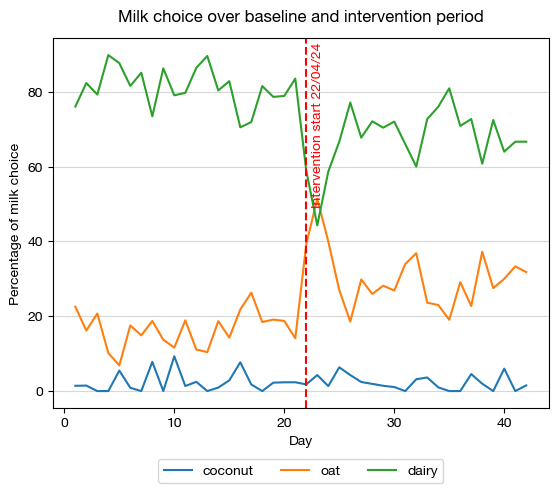

In [137]:
import matplotlib.pyplot as plt

plt.plot(combined_df['day'], combined_df['coconut%'], label='coconut')
plt.plot(combined_df['day'], combined_df['oat%'], label='oat')
plt.plot(combined_df['day'], combined_df['dairy%'], label='dairy')

intervention_start_day = 22
plt.axvline(x=intervention_start_day, color='red', linestyle='--')

plt.text(intervention_start_day+0.5, plt.ylim()[1], 'Intervention start 22/04/24 ', rotation=90, va='top', color='red')

plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.12))
plt.xlabel('Day')
plt.ylabel('Percentage of milk choice')
plt.title('Milk choice over baseline and intervention period', pad=12)

plt.grid(axis='y', alpha=0.5)

plt.savefig('milk_choice.pdf', bbox_inches="tight")

plt.show()

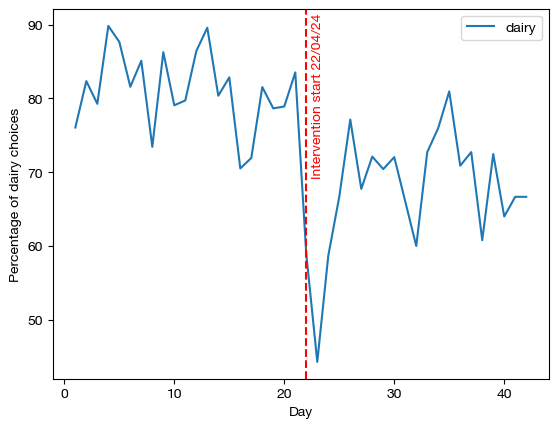

In [138]:
plt.plot(combined_df['day'], combined_df['dairy%'], label='dairy')

intervention_start_day = 22
plt.axvline(x=intervention_start_day, color='red', linestyle='--')

plt.text(intervention_start_day+0.5, plt.ylim()[1], 'Intervention start 22/04/24 ', rotation=90, va='top', color='red')

plt.legend()
plt.xlabel('Day')
plt.ylabel('Percentage of dairy choices')

plt.show()

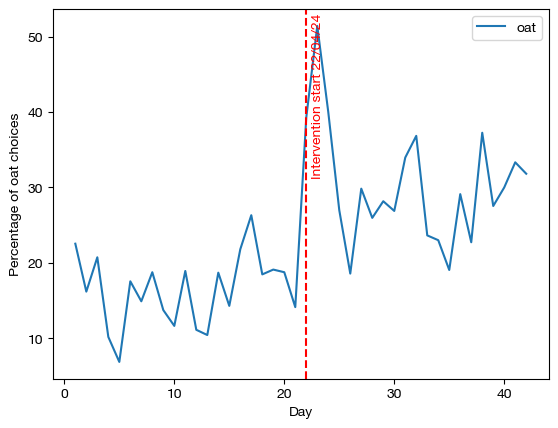

In [139]:
plt.plot(combined_df['day'], combined_df['oat%'], label='oat')

intervention_start_day = 22
plt.axvline(x=intervention_start_day, color='red', linestyle='--')

plt.text(intervention_start_day+0.5, plt.ylim()[1], 'Intervention start 22/04/24 ', rotation=90, va='top', color='red')

plt.legend()
plt.xlabel('Day')
plt.ylabel('Percentage of oat choices')

plt.show()

In [140]:
combined_df_by_week = ReportDataFrame(combined_df).group_by_week().add_percentage_columns(milk_types, "total").reset_index()
combined_df_by_week

,week,day,coconut,oat,dairy,total,black,coconut%,oat%,dairy%
0,1,7,7.0,89.0,465.0,561.0,41.0,1.247772,15.864528,82.887701
1,2,7,13.0,77.0,426.0,516.0,41.0,2.519380,14.922481,82.558140
2,3,7,15.0,102.0,420.0,537.0,37.0,2.793296,18.994413,78.212291
3,4,7,17.0,182.0,363.0,562.0,37.0,3.024911,32.384342,64.590747
4,5,7,8.0,150.0,393.0,551.0,41.0,1.451906,27.223230,71.324864
5,6,7,8.0,132.0,301.0,441.0,37.0,1.814059,29.931973,68.253968


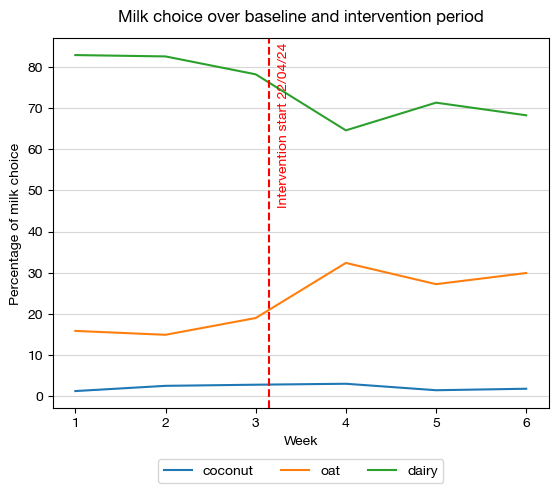

In [141]:
plt.plot(combined_df_by_week['week'], combined_df_by_week['coconut%'], label='coconut')
plt.plot(combined_df_by_week['week'], combined_df_by_week['oat%'], label='oat')
plt.plot(combined_df_by_week['week'], combined_df_by_week['dairy%'], label='dairy')

intervention_start_week = 3.143
plt.axvline(x=intervention_start_week, color='red', linestyle='--')

plt.text(intervention_start_week+0.1, plt.ylim()[1], 'Intervention start 22/04/24 ', rotation=90, va='top', color='red')

plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.12))
plt.xlabel('Week')
plt.ylabel('Percentage of milk choice')
plt.title('Milk choice over baseline and intervention period', pad=12)

plt.grid(axis='y', alpha=0.5)

plt.savefig('milk_choice_week.pdf', bbox_inches="tight")

plt.show()

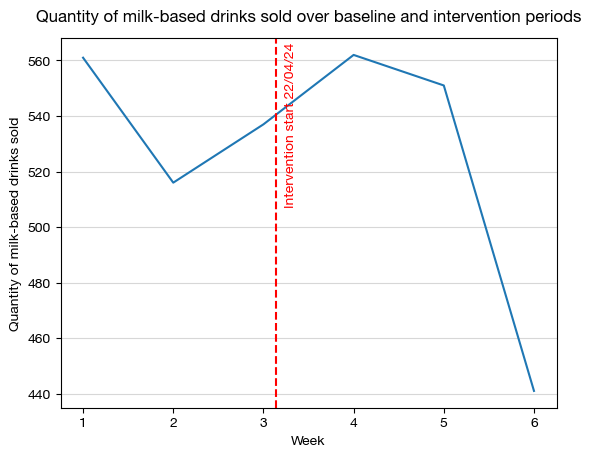

In [142]:
combined_df_by_week = ReportDataFrame(combined_df).group_by_week().reset_index()

plt.plot(combined_df_by_week['week'], combined_df_by_week['total'], label='total_sales')

intervention_start_day = 3.143
plt.axvline(x=intervention_start_day, color='red', linestyle='--')

plt.text(intervention_start_day+0.1, plt.ylim()[1], 'Intervention start 22/04/24 ', rotation=90, va='top', color='red')

# plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.12))
plt.xlabel('Week')
plt.ylabel('Quantity of milk-based drinks sold')
plt.title('Quantity of milk-based drinks sold over baseline and intervention periods', pad=12)

plt.grid(axis='y', alpha=0.5)

plt.savefig('total_milk_based.pdf', bbox_inches="tight")

plt.show()

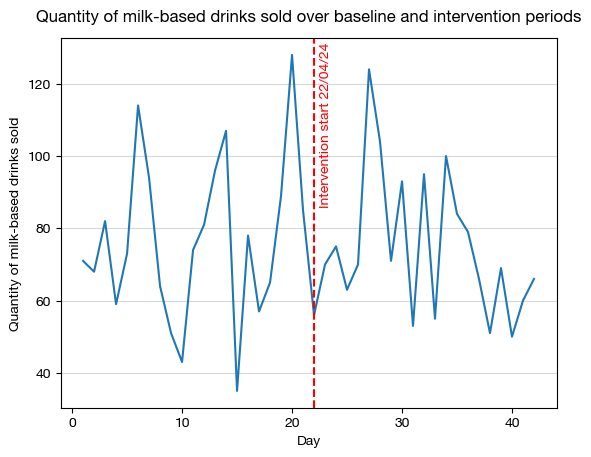

In [143]:
plt.plot(combined_df['day'], combined_df['total'], label='total_sales')

intervention_start_day = 22
plt.axvline(x=intervention_start_day, color='red', linestyle='--')

plt.text(intervention_start_day+0.5, plt.ylim()[1], 'Intervention start 22/04/24 ', rotation=90, va='top', color='red')

# plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.12))
plt.xlabel('Day')
plt.ylabel('Quantity of milk-based drinks sold')
plt.title('Quantity of milk-based drinks sold over baseline and intervention periods', pad=12)

plt.grid(axis='y', alpha=0.5)

plt.savefig('total_milk_based_daily.pdf', bbox_inches="tight")

plt.show()

In [144]:
combined_df['oat_default'] = 0
combined_df.loc[combined_df['day'] >= 22, 'oat_default'] = 1
combined_df

,day,default_milk,time_of_day,coconut,oat,dairy,total,black,coconut%,oat%,dairy%,oat_default
0,1,DAIRY MILK,ampm,1.0,16.0,54.0,71.0,10.0,1.408451,22.535211,76.056338,0
1,2,DAIRY MILK,ampm,1.0,11.0,56.0,68.0,5.0,1.470588,16.176471,82.352941,0
2,3,DAIRY MILK,ampm,0.0,17.0,65.0,82.0,2.0,0.000000,20.731707,79.268293,0
3,4,DAIRY MILK,ampm,0.0,6.0,53.0,59.0,2.0,0.000000,10.169492,89.830508,0
4,5,DAIRY MILK,ampm,4.0,5.0,64.0,73.0,9.0,5.479452,6.849315,87.671233,0
5,6,DAIRY MILK,ampm,1.0,20.0,93.0,114.0,4.0,0.877193,17.543860,81.578947,0
6,7,DAIRY MILK,ampm,0.0,14.0,80.0,94.0,9.0,0.000000,14.893617,85.106383,0
7,8,DAIRY MILK,ampm,5.0,12.0,47.0,64.0,4.0,7.812500,18.750000,73.437500,0
8,9,DAIRY MILK,ampm,0.0,7.0,44.0,51.0,4.0,0.000000,13.725490,86.274510,0
9,10,DAIRY MILK,ampm,4.0,5.0,34.0,43.0,1.0,9.302326,11.627907,79.069767,0


In [176]:
combined_df = combined_df.rename(columns={'dairy%': 'dairy_percent', 'oat%': 'oat_percent'})
combined_df_by_week = ReportDataFrame(combined_df).group_by_week().add_percentage_columns(milk_types, "total").reset_index()
combined_df_by_week = combined_df_by_week.rename(columns={'dairy%': 'dairy_percent', 'oat%': 'oat_percent'})

combined_df_by_week['oat_default'] = 0
combined_df_by_week.loc[combined_df_by_week['week'] >= 4, 'oat_default'] = 1

combined_df_by_week

,week,day,coconut,oat,dairy,total,black,coconut%,oat_percent,dairy_percent,oat_default
0,1,7,7.0,89.0,465.0,561.0,41.0,1.247772,15.864528,82.887701,0
1,2,7,13.0,77.0,426.0,516.0,41.0,2.519380,14.922481,82.558140,0
2,3,7,15.0,102.0,420.0,537.0,37.0,2.793296,18.994413,78.212291,0
3,4,7,17.0,182.0,363.0,562.0,37.0,3.024911,32.384342,64.590747,1
4,5,7,8.0,150.0,393.0,551.0,41.0,1.451906,27.223230,71.324864,1
5,6,7,8.0,132.0,301.0,441.0,37.0,1.814059,29.931973,68.253968,1


In [210]:
import patsy
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson


fam = Poisson()
f = 'dairy_percent ~ oat_default'
y, X = patsy.dmatrices(f, combined_df, return_type='matrix')

p_model = sm.GLM(y, X, family=fam)

result = p_model.fit()
print(result.summary(title='Poisson regression: dairy_percent ~ oat_default, daily.'))

           Poisson regression: dairy_percent ~ oat_default, daily.            
Dep. Variable:          dairy_percent   No. Observations:                   42
Model:                            GLM   Df Residuals:                       40
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -142.58
Date:                Wed, 05 Jun 2024   Deviance:                       27.288
Time:                        14:11:32   Pearson chi2:                     26.3
No. Iterations:                     4   Pseudo R-squ. (CS):             0.4663
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.3966      0.024    181.526      

In [198]:
fam = Poisson()
f = 'oat_percent ~ oat_default'
y, X = patsy.dmatrices(f, combined_df, return_type='matrix')

p_model = sm.GLM(y, X, family=fam)

result = p_model.fit()
print(result.summary(title='Poisson regression: oat_percent ~ oat_default, daily.'))

            Poisson regression: oat_percent ~ oat_default, daily.             
Dep. Variable:            oat_percent   No. Observations:                   42
Model:                            GLM   Df Residuals:                       40
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -136.93
Date:                Wed, 05 Jun 2024   Deviance:                       67.521
Time:                        13:59:01   Pearson chi2:                     67.8
No. Iterations:                     4   Pseudo R-squ. (CS):             0.8750
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.7989      0.054     51.985      

In [200]:
fam = Poisson()
f = 'dairy_percent ~ oat_default'
y, X = patsy.dmatrices(f, combined_df_by_week, return_type='matrix')

p_model = sm.GLM(y, X, family=fam)

result = p_model.fit()
print(result.summary(title='Poisson regression: dairy_percent ~ oat_default, weekly.'))

           Poisson regression: dairy_percent ~ oat_default, weekly.           
Dep. Variable:          dairy_percent   No. Observations:                    6
Model:                            GLM   Df Residuals:                        4
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18.697
Date:                Wed, 05 Jun 2024   Deviance:                      0.50336
Time:                        13:59:18   Pearson chi2:                    0.502
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4407
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.3972      0.064     68.638      

In [201]:
fam = Poisson()
f = 'oat_percent ~ oat_default'
y, X = patsy.dmatrices(f, combined_df_by_week, return_type='matrix')

p_model = sm.GLM(y, X, family=fam)

result = p_model.fit()
print(result.summary(title='Poisson regression: oat_percent ~ oat_default, weekly.'))

            Poisson regression: oat_percent ~ oat_default, weekly.            
Dep. Variable:            oat_percent   No. Observations:                    6
Model:                            GLM   Df Residuals:                        4
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15.326
Date:                Wed, 05 Jun 2024   Deviance:                      0.98628
Time:                        13:59:33   Pearson chi2:                    0.994
No. Iterations:                     4   Pseudo R-squ. (CS):             0.8530
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.8090      0.142     19.819      